In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample.geometry import GridDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
sys.path.append('../saildrone/subroutines/')
from read_routines import read_all_usv, read_one_usv, add_den_usv, add_flux_usv
sys.path.append('./../flux/')

import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob
import cartopy.crs as ccrs   # import projections


# Read in All Saildrone cruises downloaded from https://data.saildrone.com/data/sets
- 2017 onwards, note that earlier data is going to lack insruments and be poorer data quality in general
- For this code I want to develop a routine that reads in all the different datasets and creates a standardized set
- It may work best to first read each of the files individually into a dictionary 
- then go through each dataset finding all variable names
- I decided to put all SST into TEMP_CTD_MEAN and same for Salinity so there is a single variable name
- this still preserves all the dataset information

In [2]:
dir_data = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/*.nc' 

#dir_out = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day/'
#dir_fig = 'F:/data/cruise_data/saildrone/sss/figs/'
dir_out = '//White_home_pc/f/data/cruise_data/saildrone/sss/sss_collocations_8day/'
dir_fig = '//White_home_pc/f/data/cruise_data/saildrone/sss/figs/'

#get list of all filenames in directory
files = [x for x in glob(dir_data+'*.nc')]
print('number of file:',len(files))


number of file: 44


0 C:/Users/gentemann/Google Drive/public/2019_saildrone\PMEL_Arctic_2015_sd126-ALL-1_min-v1.nc
1 C:/Users/gentemann/Google Drive/public/2019_saildrone\PMEL_Arctic_2015_sd128-ALL-1_min-v1.nc


KeyboardInterrupt: 

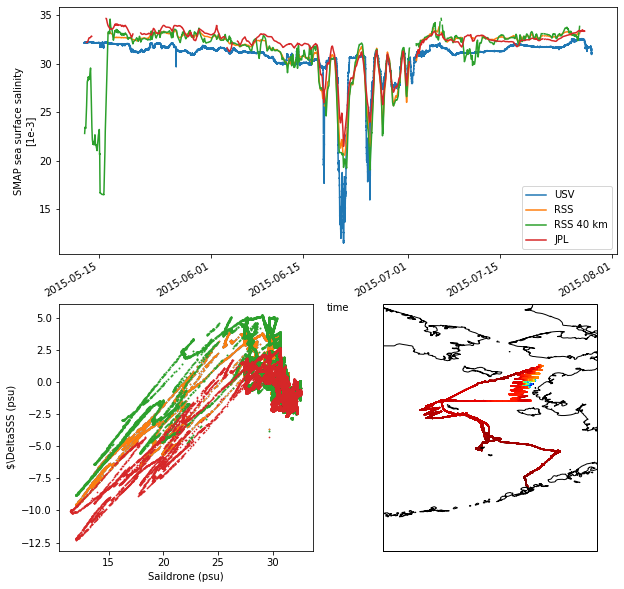

In [12]:
for ifile,file in enumerate(files):
#    if not ifile==0:
#        continue
    print(ifile,file)
    ds_usv,name = read_one_usv(file)
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    
    ds_usv = add_den_usv(ds_usv)
    ds_usv = add_flux_usv(ds_usv,1.0)
    
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    fin = dir_out+name+'_RSS8dy'+'.nc'
    ds_rss = xr.open_dataset(fin)
    fin = dir_out+name+'_JPL8dy'+'.nc'
    ds_jpl = xr.open_dataset(fin)
    plt.figure(figsize=(10,10))
    dx,dy=3,5
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data-dx,ds_usv.lon.max().data+dx
    y1,y2=ds_usv.lat.min().data-dy,ds_usv.lat.max().data+dy

    ax1 = plt.subplot(211)
    ds_usv.SAL_CTD_MEAN.plot(ax=ax1,label='USV')
    ds_rss.sss_smap.plot(ax=ax1,label='RSS')
    ds_rss.sss_smap_40km.plot(ax=ax1,label='RSS 40 km')
    ds_jpl.smap_sss.plot(ax=ax1,label='JPL')
    ax1.legend()
    ax2 = plt.subplot(223)
    ds_rss2 = ds_rss.where(ds_rss.sss_smap>-10)
    ax2.scatter(ds_usv.SAL_CTD_MEAN,ds_usv.SAL_CTD_MEAN-ds_rss.sss_smap,label='USV - RSS',s=.5) #to get color right 
    ax2.scatter(ds_usv.SAL_CTD_MEAN,ds_usv.SAL_CTD_MEAN-ds_rss.sss_smap,label='USV - RSS',s=.5)
    ax2.scatter(ds_usv.SAL_CTD_MEAN,ds_usv.SAL_CTD_MEAN-ds_rss2.sss_smap_40km,label='USV - RSS 40 k',s=1)
    ax2.scatter(ds_usv.SAL_CTD_MEAN,ds_usv.SAL_CTD_MEAN-ds_jpl.smap_sss,label='USV - JPL',s=.5)
    ax2.set_xlabel('Saildrone (psu)')
    ax2.set_ylabel('$\DeltaSSS (psu)')
    ax3 = plt.subplot(224,projection = ccrs.PlateCarree())
    ds2 = ds_usv
    im=ax3.scatter(ds2.lon,ds2.lat,c=ds2.SAL_CTD_MEAN,s=.15,transform=ccrs.PlateCarree(),cmap='jet')
    ax3.coastlines(resolution='10m')                
    ax3.set_extent([x1,x2,y1,y2])
    dir_fig = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/figs/'
    plt.savefig(dir_fig+'sss_timeseries'+name+'.png')


NameError: name 'ds' is not defined

In [4]:
ds_usv

<xarray.Dataset>
Dimensions:                       (time: 123530, traj: 1)
Coordinates:
  * traj                          (traj) float64 1.0
    obs                           (time) float64 1.0 2.0 3.0 ... 366.0 367.0
  * time                          (time) datetime64[ns] 2015-05-04T00:00:15 ... 2015-07-28T19:58:16
Data variables:
    lat                           (time) float64 57.07 57.07 ... 53.84 53.84
    lon                           (time) float64 -165.5 -165.5 ... -166.6 -166.6
    TEMP_AIR_MEAN                 (time) float64 nan nan 2.96 ... nan nan nan
    RH_MEAN                       (time) float64 nan nan 91.73 ... nan nan nan
    BARO_PRES_MEAN                (time) float64 nan nan 1.02e+03 ... nan nan
    SAL_CTD_MEAN                  (time) float64 31.87 31.87 ... 0.0543 0.0512
    TEMP_CTD_MEAN                 (time) float64 3.76 3.78 3.79 ... 8.66 8.71
    TEMP_CTD_STDDEV               (time) float64 ...
    CDOM_MEAN                     (time) float64 ...
    CHLOR_MEAN                    (time) float64 ...
    PAR_AIR_MEAN                  (time) float64 ...
    GUST_WND_MEAN                 (time) float64 ...
    UWND_MEAN                     (time) float64 nan nan 6.753 ... nan nan nan
    VWND_MEAN                     (time) float64 nan nan 1.386 ... nan nan nan
    SOG_MEAN                      (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    COG_MEAN                      (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    HDG_MEAN                      (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    ROLL_MEAN                     (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    PITCH_MEAN                    (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    WWND_MEAN                     (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    TEMP_RBR_MEAN                 (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    SAL_RBR_MEAN                  (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    TEMP_O2_RBR_MEAN              (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    CHLOR_WETLABS_MEAN            (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    WIND_MEASUREMENT_HEIGHT_MEAN  (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    wspd                          (time) float64 nan nan 6.894 ... nan nan nan
    density_mean                  (time) float64 1.025e+03 1.025e+03 ... 999.8
    alpha_ME                      (time) float64 nan nan 9.128e-05 ... nan nan
    beta_MEAN                     (time) float64 nan nan 0.000776 ... nan nan
    dist_total                    (time) float64 0.07843 0.1714 ... 5.491e+03
    dist_between                  (time) float64 0.07843 0.09302 ... 0.06127
Attributes:
    history:      FERRET V7.3  19-Dec-17
    Conventions:  CF-1.6
    featureType:  trajectory
    project:      PMEL_Arctic_2015
    vehicle_id:   sd128

In [8]:
ds_usv

<xarray.Dataset>
Dimensions:                       (time: 123530, traj: 1)
Coordinates:
  * traj                          (traj) float64 1.0
    obs                           (time) float64 1.0 2.0 3.0 ... 366.0 367.0
  * time                          (time) datetime64[ns] 2015-05-04T00:00:15 ... 2015-07-28T19:58:16
Data variables:
    lat                           (time) float64 57.07 57.07 ... 53.84 53.84
    lon                           (time) float64 -165.5 -165.5 ... -166.6 -166.6
    TEMP_AIR_MEAN                 (time) float64 nan nan 2.96 ... nan nan nan
    RH_MEAN                       (time) float64 nan nan 91.73 ... nan nan nan
    BARO_PRES_MEAN                (time) float64 nan nan 1.02e+03 ... nan nan
    SAL_CTD_MEAN                  (time) float64 31.87 31.87 ... 0.0543 0.0512
    TEMP_CTD_MEAN                 (time) float64 3.76 3.78 3.79 ... 8.66 8.71
    TEMP_CTD_STDDEV               (time) float64 ...
    CDOM_MEAN                     (time) float64 ...
    CHLOR_MEAN                    (time) float64 ...
    PAR_AIR_MEAN                  (time) float64 ...
    GUST_WND_MEAN                 (time) float64 ...
    UWND_MEAN                     (time) float64 nan nan 6.753 ... nan nan nan
    VWND_MEAN                     (time) float64 nan nan 1.386 ... nan nan nan
    SOG_MEAN                      (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    COG_MEAN                      (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    HDG_MEAN                      (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    ROLL_MEAN                     (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    PITCH_MEAN                    (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    WWND_MEAN                     (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    TEMP_RBR_MEAN                 (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    SAL_RBR_MEAN                  (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    TEMP_O2_RBR_MEAN              (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    CHLOR_WETLABS_MEAN            (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    WIND_MEASUREMENT_HEIGHT_MEAN  (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    wspd                          (time) float64 nan nan 6.894 ... nan nan nan
    density_mean                  (time) float64 1.025e+03 1.025e+03 ... 999.8
    alpha_ME                      (time) float64 nan nan 9.128e-05 ... nan nan
    beta_MEAN                     (time) float64 nan nan 0.000776 ... nan nan
    dist_total                    (time) float64 0.07843 0.1714 ... 5.491e+03
    dist_between                  (time) float64 0.07843 0.09302 ... 0.0006523
Attributes:
    history:      FERRET V7.3  19-Dec-17
    Conventions:  CF-1.6
    featureType:  trajectory
    project:      PMEL_Arctic_2015
    vehicle_id:   sd128

In [ ]:

dx,dy=3,5
t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
x1,x2=ds_usv.lon.min().data-dx,ds_usv.lon.max().data+dx
y1,y2=ds_usv.lat.min().data-dy,ds_usv.lat.max().data+dy

fig = plt.figure(figsize=(8,8))
#ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=180.0))  # create a set of axes with Mercator projection
ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
ds2 = ds_usv
im=ax.scatter(ds2.lon,ds2.lat,c=ds2.SAL_CTD_MEAN,s=.15,transform=ccrs.PlateCarree(),cmap='jet')
ax.coastlines(resolution='10m')                
ax.set_extent([x1,x2,y1,y2])
#ax.legend()
cax = fig.add_axes([0.45, 0.17, 0.3, 0.02])
cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
cbar.set_label('SSS (psu)')
#fig.savefig(fig_dir+'figs/map_nasa'+str(i).zfill(2)+'_data.png')    


In [ ]:
d= np.datetime64('2020-07-10')
30*6


In [ ]:
d.astype(object).toordinal()